<a href="https://colab.research.google.com/github/jsansao/teic-20231/blob/main/TEIC_Licao18_RNN_MNIST_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Classificação de Dígitos MNIST com RNN (LSTM)

Este notebook demonstra como usar uma Rede Neural Recorrente (RNN), especificamente uma camada LSTM, para classificar os dígitos manuscritos do dataset MNIST.

Ao contrário das Redes Convolucionais (CNNs) que olham para patches 2D, trataremos cada imagem como uma sequência.

* Uma imagem MNIST tem **28x28 pixels**.
* Nós alimentaremos a RNN com **28 passos no tempo (timesteps)** (um para cada linha da imagem).
* Em cada passo, a RNN receberá **28 recursos (features)** (os 28 pixels daquela linha).

A tarefa é uma classificação "muitos-para-um": a rede lê 28 entradas sequenciais e, ao final, deve prever uma única saída (qual dígito é, de 0 a 9).


## 1. Importações

In [1]:
# Importa as bibliotecas necessárias
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

print(f"Versão do TensorFlow: {tf.__version__}")

Versão do TensorFlow: 2.19.0



## 2. Carregar e Preparar os Dados
#
Carregamos o dataset MNIST e fazemos duas preparações principais:
 1.  **Normalização:** Convertemos os pixels de `0-255` para `0.0-1.0`. Isso ajuda o treinamento da rede neural a convergir mais rápido.
2.  **One-Hot Encoding:** Convertemos os labels (ex: `5`) para um formato categórico (ex: `[0,0,0,0,0,1,0,0,0,0]`), que é o que a função de perda `categorical_crossentropy` espera.




## 2. Carregar e Preparar os Dados


In [2]:

# Carrega os dados de treino e teste
(X_train, y_train_original), (X_test, y_test_original) = mnist.load_data()

# Normalização: Converte os valores dos pixels de 0-255 para 0-1
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Os dados já estão no formato que queremos: (amostras, timesteps, features)
# (60000, 28, 28) -> 60000 amostras, 28 passos no tempo, 28 features por passo
print(f"Formato de X_train: {X_train.shape}")
print(f"Formato de X_test: {X_test.shape}")

# One-Hot Encoding dos labels (y)
# Ex: 5 -> [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
y_train = to_categorical(y_train_original, 10)
y_test = to_categorical(y_test_original, 10)

print(f"Formato de y_train (após one-hot): {y_train.shape}")
print(f"Formato de y_test (após one-hot): {y_test.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Formato de X_train: (60000, 28, 28)
Formato de X_test: (10000, 28, 28)
Formato de y_train (após one-hot): (60000, 10)
Formato de y_test (após one-hot): (10000, 10)



## 3. Visualizar os Dados

Vamos dar uma olhada em alguns dos dígitos que vamos classificar.


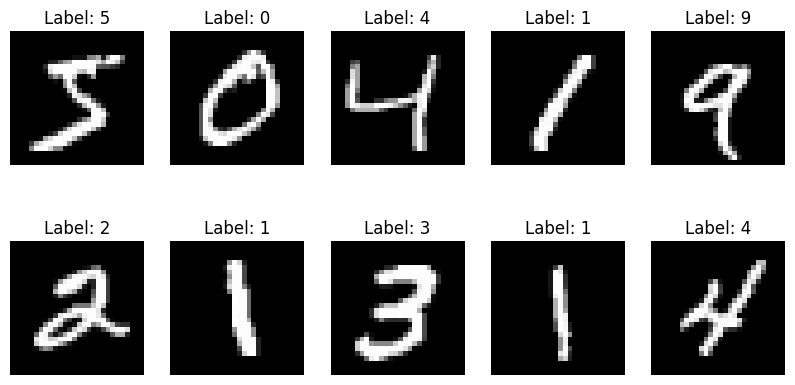

In [3]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f"Label: {y_train_original[i]}")
    plt.axis('off')
plt.show()

## 4. Construção do Modelo RNN (LSTM)

 Agora, construímos nosso modelo.

 * **Input(shape=(28, 28))**: Define a entrada. 28 timesteps, 28 features.
 * **LSTM(128)**: Nossa camada recorrente com 128 unidades de memória. Ela processará a sequência e, como é a última (ou única) camada recorrente, ela retornará apenas a saída do *último* passo no tempo.
 * **Dropout(0.2)**: Uma camada de regularização para ajudar a prevenir overfitting.
 * **Dense(10, activation='softmax')**: A camada de saída final. Ela pega o vetor de 128 unidades da LSTM e o comprime em 10 probabilidades, uma para cada dígito (0-9).



In [4]:
# Define as constantes do modelo
TIMESTEPS = 28
FEATURES = 28
NUM_CLASSES = 10

model = Sequential([
    # Define a camada de entrada com o formato (timesteps, features)
    Input(shape=(TIMESTEPS, FEATURES)),

    # Camada LSTM com 128 neurônios
    # Não precisamos de 'return_sequences=True' porque só queremos
    # a saída do último passo no tempo para a classificação final.
    LSTM(128),

    # Dropout para regularização
    Dropout(0.2),

    # Camada de saída final com 10 neurônios (um para cada classe)
    # e ativação 'softmax' para obter probabilidades.
    Dense(NUM_CLASSES, activation='softmax')
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        80,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,674 (319.04 KB)

 Trainable params: 81,674 (319.04 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Compilar o Modelo

Antes de treinar, precisamos compilar o modelo com:
 * **loss**: A função para medir o erro (`categorical_crossentropy` é padrão para classificação multiclasse com one-hot).
 * **optimizer**: O algoritmo para atualizar os pesos (`adam` é um ótimo otimizador padrão).
 * **metrics**: O que queremos monitorar (`accuracy`).


In [5]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

## 6. Treinar o Modelo

 Agora, alimentamos o modelo com nossos dados de treino.

 * `epochs=10`: O modelo verá o dataset de treino completo 10 vezes.
 * `batch_size=128`: O modelo atualizará seus pesos após ver 128 amostras.
 * `validation_data=(X_test, y_test)`: Permite monitorar a acurácia no conjunto de teste em tempo real, ao final de cada época.


In [6]:
print("Iniciando o treinamento...")

history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=128,
    validation_data=(X_test, y_test),
    verbose=1
)

print("Treinamento concluído.")

Iniciando o treinamento...
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 44s 88ms/step - accuracy: 0.6853 - loss: 0.9377 - val_accuracy: 0.9517 - val_loss: 0.1582
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 86ms/step - accuracy: 0.9488 - loss: 0.1670 - val_accuracy: 0.9625 - val_loss: 0.1186
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 87ms/step - accuracy: 0.9670 - loss: 0.1099 - val_accuracy: 0.9673 - val_loss: 0.1108
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 84ms/step - accuracy: 0.9716 - loss: 0.0896 - val_accuracy: 0.9748 - val_loss: 0.0800
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 88ms/step - accuracy: 0.9786 - loss: 0.0711 - val_accuracy: 0.9815 - val_loss: 0.0649
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 80s 84ms/step - accuracy: 0.9835 - loss: 0.0560 - val_accuracy: 0.9782 - val_loss: 0.0698
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 84ms/step - accuracy: 0.9853 - loss: 0.0476 - val_accuracy: 0.9808 - val_loss: 0.0605
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 43s 88ms/step - accurac

## 7. Avaliar o Desempenho

 Vamos plotar a acurácia e a perda (loss) ao longo das épocas para ver como o modelo aprendeu. Também imprimiremos a acurácia final no conjunto de teste.



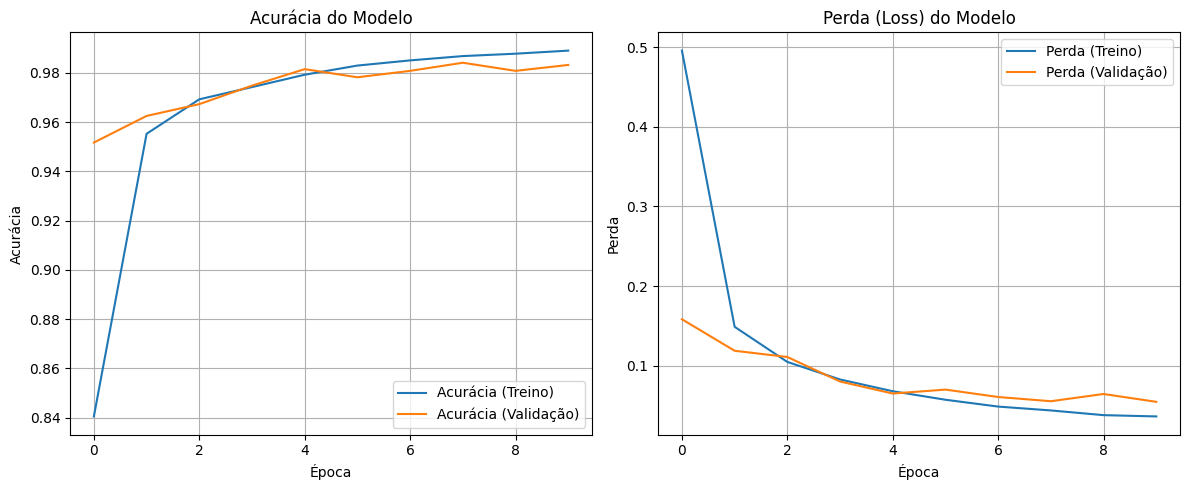


--- Resultados Finais ---
Perda (Loss) no Teste: 0.0545
Acurácia no Teste: 98.32%


In [7]:

# Plotar gráficos de Acurácia e Perda
plt.figure(figsize=(12, 5))

# Gráfico da Acurácia
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Acurácia (Treino)')
plt.plot(history.history['val_accuracy'], label='Acurácia (Validação)')
plt.title('Acurácia do Modelo')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)

# Gráfico da Perda (Loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Perda (Treino)')
plt.plot(history.history['val_loss'], label='Perda (Validação)')
plt.title('Perda (Loss) do Modelo')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Avaliação final no conjunto de teste
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("\n--- Resultados Finais ---")
print(f"Perda (Loss) no Teste: {loss:.4f}")
print(f"Acurácia no Teste: {accuracy * 100:.2f}%")


## 8. Testar com Previsões

Vamos pegar algumas imagens do conjunto de teste e ver o que o modelo prevê.


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


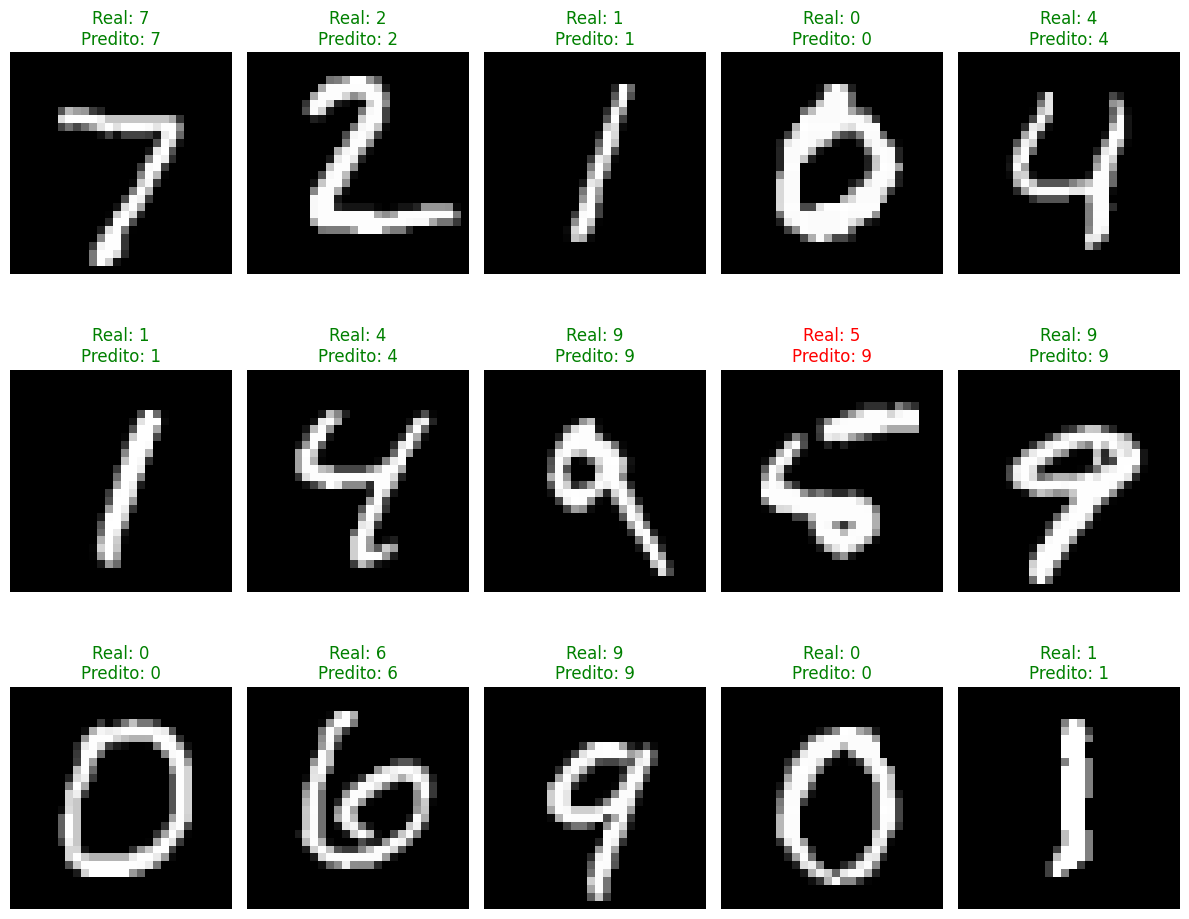

In [9]:


# Faz previsões para todo o conjunto de teste
predictions = model.predict(X_test)

# Pega o índice da classe com maior probabilidade (essa é a previsão)
predicted_labels = np.argmax(predictions, axis=1)

# Mostra algumas imagens de teste com seus labels preditos vs. reais
plt.figure(figsize=(12, 10))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(X_test[i], cmap='gray')

    # O label real é o que usamos originalmente
    true_label = y_test_original[i]
    # O label predito é o que o modelo calculou
    pred_label = predicted_labels[i]

    color = 'green' if true_label == pred_label else 'red'
    plt.title(f"Real: {true_label}\nPredito: {pred_label}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()